#패키지 import

In [ ]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18 ,resnet50, resnet101
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

from pathlib import Path
from torch.utils.data import Dataset
# from torchvision.io import read_image
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torchvision.transforms as transforms

import os
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
# from torchvision.io import read_image
from PIL import Image
import logging

#TaskSampler Class 정의

In [ ]:
import random
from typing import List, Tuple, Iterator

import torch
from torch import Tensor
from torch.utils.data import Sampler

from easyfsl.datasets import FewShotDataset


class TaskSampler(Sampler):
    """
    Samples batches in the shape of few-shot classification tasks. At each iteration, it will sample
    n_way classes, and then sample support and query images from these classes.
    """

    def __init__(
        self,
        dataset: FewShotDataset,
        n_way: int,
        n_shot: int,
        n_query: int,
        n_tasks: int,
    ):
        """
        Args:
            dataset: dataset from which to sample classification tasks. Must have a field 'label': a
                list of length len(dataset) containing containing the labels of all images.
            n_way: number of classes in one task
            n_shot: number of support images for each class in one task
            n_query: number of query images for each class in one task
            n_tasks: number of tasks to sample
        """
        super().__init__(data_source=None)
        self.n_way = n_way
        self.n_shot = n_shot
        self.n_query = n_query
        self.n_tasks = n_tasks

        self.items_per_label = {}
        for item, label in enumerate(dataset.get_labels()):
            if label in self.items_per_label.keys():
                self.items_per_label[label].append(item)
            else:
                self.items_per_label[label] = [item]

    def __len__(self) -> int:
        return self.n_tasks

    def __iter__(self) -> Iterator[List[int]]:
        for _ in range(self.n_tasks):
            yield torch.cat(
                [
                    # pylint: disable=not-callable
                    torch.tensor(
                        random.sample(
                            self.items_per_label[label], self.n_shot + self.n_query
                        )
                    )
                    # pylint: enable=not-callable
                    for label in random.sample(self.items_per_label.keys(), self.n_way)
                ]
            ).tolist()

    def episodic_collate_fn(
        self, input_data: List[Tuple[Tensor, int]]
    ) -> Tuple[Tensor, Tensor, Tensor, Tensor, List[int]]:
        """
        Collate function to be used as argument for the collate_fn parameter of episodic
            data loaders.
        Args:
            input_data: each element is a tuple containing:
                - an image as a torch Tensor
                - the label of this image
        Returns:
            tuple(Tensor, Tensor, Tensor, Tensor, list[int]): respectively:
                - support images,
                - their labels,
                - query images,
                - their labels,
                - the dataset class ids of the class sampled in the episode
        """

        true_class_ids = list({x[1] for x in input_data})

        all_images = torch.cat([x[0].unsqueeze(0) for x in input_data])
        all_images = all_images.reshape(
            (self.n_way, self.n_shot + self.n_query, *all_images.shape[1:])
        )
        # pylint: disable=not-callable
        all_labels = torch.tensor(
            [true_class_ids.index(x[1]) for x in input_data]
        ).reshape((self.n_way, self.n_shot + self.n_query))
        # pylint: enable=not-callable

        support_images = all_images[:, : self.n_shot].reshape(
            (-1, *all_images.shape[2:])
        )
        query_images = all_images[:, self.n_shot :].reshape((-1, *all_images.shape[2:]))
        support_labels = all_labels[:, : self.n_shot].flatten()
        query_labels = all_labels[:, self.n_shot :].flatten()

        return (
            support_images,
            support_labels,
            query_images,
            query_labels,
            true_class_ids,
        )

# FewShotClassifier 정의

In [ ]:
from abc import abstractmethod

import torch
from torch import nn, Tensor

from easyfsl.utils import compute_backbone_output_shape, compute_prototypes


class FewShotClassifier(nn.Module):
    """
    Abstract class providing methods usable by all few-shot classification algorithms
    """

    def __init__(self, backbone: nn.Module, use_softmax: bool = False):
        """
        Initialize the Few-Shot Classifier
        Args:
            backbone: the feature extractor used by the method. Must output a tensor of the
                appropriate shape (depending on the method)
            use_softmax: whether to return predictions as soft probabilities
        """
        super().__init__()

        self.backbone = backbone
        self.backbone_output_shape = compute_backbone_output_shape(backbone)
        self.feature_dimension = self.backbone_output_shape[0]

        self.use_softmax = use_softmax

        self.prototypes = None
        self.support_features = None
        self.support_labels = None

    @abstractmethod
    def forward(
        self,
        query_images: Tensor,
    ) -> Tensor:
        """
        Predict classification labels.
        Args:
            query_images: images of the query set
        Returns:
            a prediction of classification scores for query images
        """
        raise NotImplementedError(
            "All few-shot algorithms must implement a forward method."
        )

    @abstractmethod
    def process_support_set(
        self,
        support_images: Tensor,
        support_labels: Tensor,
    ):
        """
        Harness information from the support set, so that query labels can later be predicted using
        a forward call
        Args:
            support_images: images of the support set
            support_labels: labels of support set images
        """
        raise NotImplementedError(
            "All few-shot algorithms must implement a process_support_set method."
        )

    @staticmethod
    def is_transductive() -> bool:
        raise NotImplementedError(
            "All few-shot algorithms must implement a is_transductive method."
        )

    def softmax_if_specified(self, output: Tensor) -> Tensor:
        """
        If the option is chosen when the classifier is initialized, we perform a softmax on the
        output in order to return soft probabilities.
        Args:
            output: output of the forward method
        Returns:
            output as it was, or output as soft probabilities
        """
        return output.softmax(-1) if self.use_softmax else output

    def l2_distance_to_prototypes(self, samples: Tensor) -> Tensor:
        """
        Compute prediction logits from their euclidean distance to support set prototypes.
        Args:
            samples: features of the items to classify
        Returns:
            prediction logits
        """
        return -torch.cdist(samples, self.prototypes)

    def cosine_distance_to_prototypes(self, samples) -> Tensor:
        """
        Compute prediction logits from their cosine distance to support set prototypes.
        Args:
            samples: features of the items to classify
        Returns:
            prediction logits
        """
        return (
            nn.functional.normalize(samples, dim=1)
            @ nn.functional.normalize(self.prototypes, dim=1).T
        )

    def store_support_set_data(
        self,
        support_images: Tensor,
        support_labels: Tensor,
    ):
        """
        Extract support features, compute prototypes,
            and store support labels, features, and prototypes
        Args:
            support_images: images of the support set
            support_labels: labels of support set images
        """
        self.support_labels = support_labels
        self.support_features = self.backbone(support_images)
        self.prototypes = compute_prototypes(self.support_features, support_labels)

#validate root dir, customDataset정의

In [ ]:
def _validate_root_dir(root):
    # todo: raise exception or warning
    pass

def _validate_train_flag(train: bool, valid: bool, test: bool):
    assert [train, valid, test].count(True)==1, "one of train, valid & test must be true."        

class CustomDataset(Dataset):        
    def __init__(self, root,
                 train: bool = False, valid: bool = False, test: bool = False,
                 transform=None, target_transform=None,):

        _validate_root_dir(root)
        _validate_train_flag(train, valid, test)        
        self.transform = transform
        self.target_transform = target_transform
        if train:
            self.data_dir = Path(root)/'train'
        elif valid:
            self.data_dir = Path(root)/'valid'
        elif test:
            self.data_dir = Path(root)/'test'        
    
        self._image_paths = sorted(
            list(self.data_dir.glob("**/*.jpg"))+
            list(self.data_dir.glob("**/*.jpeg"))+
            list(self.data_dir.glob("**/*.png")))
        self._image_labels = [int(i.parent.name) for i in self._image_paths]
        assert len(self._image_paths)==len(self._image_labels)
        
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx):
        x = Image.open(str(self._image_paths[idx]))
        y = self._image_labels[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(x)
        return x, y
    def get_labels(self):
        return self._image_labels

image_size = 128
data_dir = '/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/pest'

# train set is list of (x, y) 
# where x is single image and y is label corresponding to it.

#########################이미지 전처리 및 train_set valid_set 정의
train_set = CustomDataset(
    root=data_dir,
    train=True,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.5), int(image_size * 1.5)]),
            transforms.RandomPerspective(0.5, 0.8),
            transforms.CenterCrop(image_size),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.15, saturation=0, hue=0,
            ),
            transforms.ToTensor(),
        ]
    ),
)
valid_set = CustomDataset(
    root=data_dir,
    valid=True,
    transform=transforms.Compose(
        [
            # If images have 1 channel, our model will expect 3-channel images
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

#prototypicalNetworks 정의

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores
convolutional_network = resnet50(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PrototypicalNetworks(convolutional_network).cuda()
model = PrototypicalNetworks(convolutional_network).to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
N_WAY = 41# 5  # Number of classes in a task
N_SHOT = 9 # 5  # Number of images per class in the support set
N_QUERY = 1 # 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100 

valid_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

valid_loader = DataLoader(
    train_set,
    batch_sampler=valid_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=valid_sampler.episodic_collate_fn,
)

#라벨 시각화

tensor([20, 34,  8, 16, 11, 29, 21, 19,  3, 24, 10, 25, 33, 18, 32, 30, 14,  9,
        12, 37,  1, 27, 28, 15, 36, 17, 39,  6,  7, 38, 23, 31, 22,  4, 13,  0,
         5,  2, 35, 40, 26])
tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 34, 34, 34, 34, 34, 34, 34, 34,
         8,  8,  8,  8,  8,  8,  8,  8,  8, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 19, 19, 19, 19, 19, 19, 19, 19, 19,
         3,  3,  3,  3,  3,  3,  3,  3,  3, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        14, 14, 14, 14, 14, 14, 14, 14, 14,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 37, 37, 37, 37, 37, 37, 37, 37, 37,
         1,

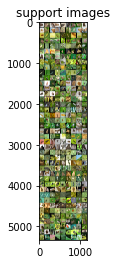

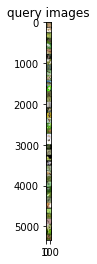

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(valid_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
print(example_query_labels)
print(example_support_labels)
print(example_class_ids)
plot_images(example_query_images, "query images", images_per_row=N_QUERY) 

In [ ]:
device

device(type='cuda')

In [ ]:
torch.cuda.is_available()

True

#예시 평가 해보기

In [ ]:
model.eval()
example_scores = model(
    example_support_images.to(device), #.cuda(),
    example_support_labels.to(device),#.cuda(),
    example_query_images.to(device), #.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted") 
for i in range(len(example_query_labels)):
    print(
        f"{valid_set._image_labels[example_class_ids[example_query_labels[i]]]} / {valid_set._image_labels[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
11 / 18
18 / 2
5 / 1
9 / 4
7 / 17
16 / 13
12 / 21
11 / 11
3 / 20
13 / 17
6 / 6
14 / 14
18 / 19
10 / 6
17 / 14
16 / 12
8 / 19
6 / 15
7 / 19
20 / 20
2 / 2
15 / 15
15 / 15
9 / 14
19 / 19
10 / 10
21 / 4
4 / 12
5 / 2
20 / 12
13 / 3
17 / 3
12 / 12
3 / 1
8 / 8
1 / 12
4 / 3
2 / 5
19 / 19
21 / 8
14 / 1


#Evaluate 함수 정의

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
#             model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)#.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )
            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(valid_loader)

100%|██████████| 100/100 [07:40<00:00,  4.61s/it]

Model tested on 100 tasks. Accuracy: 37.90%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

#Trainloader 정의

In [ ]:
N_TRAINING_EPISODES = 400
N_VALIDATION_TASKS = 100

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

#Loss,optim정의

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
#         support_images.cuda(), support_labels.cuda(), query_images.cuda()
        support_images.to(device), support_labels.to(device), query_images.to(device)
    )

    loss = criterion(classification_scores, query_labels.to(device))#query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

#Model 학습 시키기

In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)
        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  2%|▏         | 7/400 [00:45<42:36,  6.51s/it, loss=1.95]


KeyboardInterrupt: ignored

#

#모델 테스트

In [ ]:
test_set = CustomDataset(
    root=data_dir,
    test=True,
    transform=transforms.Compose(
        [
            # If images have 1 channel, our model will expect 3-channel images
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

N_WAY = 41 # 5  # Number of classes in a task
N_SHOT = 2 # 5  # Number of images per class in the support set
N_QUERY = 1 # 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100 

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
print(example_query_labels)
print(example_support_labels)
print(example_class_ids)
plot_images(example_query_images, "query images", images_per_row=N_QUERY) 

In [ ]:
evaluate(valid_loader)


In [ ]:
torch.save(model, 'model_re11.pt')

In [ ]:
#model = torch.load('model.pt')  #모델 불러오기